In [1]:
import os

import matplotlib.pyplot as plt

import main
import network
from lammps_scripts import ElasticScript
from main import (
    CalculationResult,
    CalculationSetup,
    ElasticData,
    StepResult,
    get_elastic_data_from_file,
    run_iteration,
    run_lammps,
)


def plot_opt_history(log_dir: str, log_file:str = "optimization_log.pkl"):
    opt_history = main.load_optimization_log(os.path.join(log_dir, log_file))
    Bs = [step.dG.bulk_modulus for step in opt_history]
    Gs = [step.dG.shear_modulus for step in opt_history]
    Ps = [step.dG.p_ratio for step in opt_history]
    Zs = [step.network.coordination_number for step in opt_history]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), layout='tight')
    # P graph
    axs[0].plot(Zs, Ps, label='P')
    axs[0].set_ylabel("$P$")
    axs[0].set_xlabel("$Z$")
    # moduli graph
    axs[1].plot(Zs, Bs, label='$B$')
    axs[1].plot(Zs, Gs, label='$G$')
    axs[1].set_ylabel("Moduli")
    axs[1].set_xlabel("$Z$")
    axs[1].legend()
    plt.show()

    return opt_history


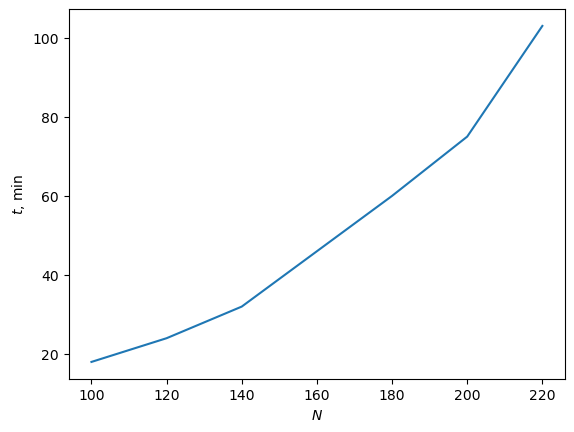

In [2]:
import numpy as np

steps = np.array([100, 120, 140, 160, 180, 200, 220])
time = np.array([18, 24, 32, 46, 60, 75, 103])

plt.plot(steps, time)
plt.ylabel("$t$, min")
plt.xlabel("$N$")
plt.show()

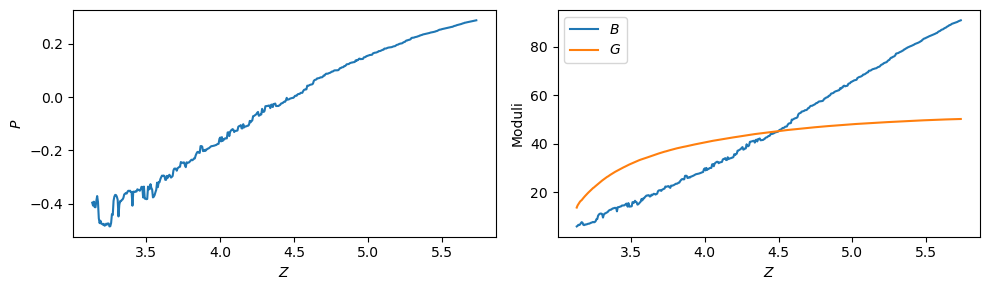

In [14]:
# orig_history = plot_opt_history("/home/sergey/work/auxetic_optimizer/successful_cases/", log_file="small_auxetic_0.01.pkl")
new_history = plot_opt_history("/home/sergey/work/auxetic_optimizer/auxetic_data/360/1")


In [16]:
init_networks: list[network.Network] = []
opt_networks: list[network.Network] = []
for nd in os.listdir("/home/sergey/work/auxetic_optimizer/auxetic_data"):
    try:
        nd = int(nd)
        for sd in os.listdir(os.path.join("/home/sergey/work/auxetic_optimizer/auxetic_data", str(nd))):
            init_networks.append(
                network.Network.from_data_file(
                    os.path.join("/home/sergey/work/auxetic_optimizer/auxetic_data", str(nd), sd, "original_network.lmp"),
                    include_angles=True,
                    include_dihedrals=False
                )
            )
            opt_networks.append(
                network.Network.from_data_file(
                    os.path.join("/home/sergey/work/auxetic_optimizer/auxetic_data", str(nd), sd, "final_result.lmp"),
                    include_angles=True,
                    include_dihedrals=False
                )
            )
    except ValueError:
        pass

init_elastic_data: list[ElasticData] = []
for nd in os.listdir("/home/sergey/work/auxetic_optimizer/auxetic_data/"):
    try:
        nd = int(nd)
        for sd in os.listdir(os.path.join("/home/sergey/work/auxetic_optimizer/auxetic_data", str(nd))):
            init_elastic_data.append(
                main.load_optimization_log(
                    os.path.join("/home/sergey/work/auxetic_optimizer/auxetic_data", str(nd), sd, "optimization_log.pkl"),
                )
            )
    except ValueError:
        pass

init_zs = [n.coordination_number for n in init_networks]
opt_zs = [n.coordination_number for n in opt_networks]
init_ps = [n[0].dG.p_ratio for n in init_elastic_data]
opt_ps = [n[-1].dG.p_ratio for n in init_elastic_data]

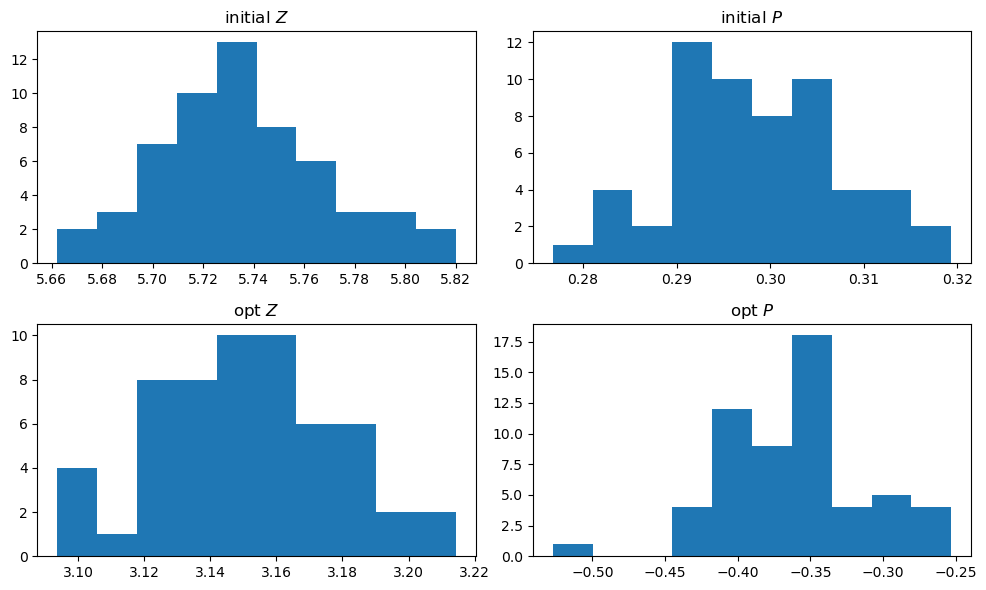

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), layout='tight')
ax[0][0].hist(init_zs)
ax[0][0].set_title("initial $Z$")
ax[0][1].hist(init_ps)
ax[0][1].set_title("initial $P$")
ax[1][0].hist(opt_zs)
ax[1][0].set_title("opt $Z$")
ax[1][1].hist(opt_ps)
ax[1][1].set_title("opt $P$")
plt.show()

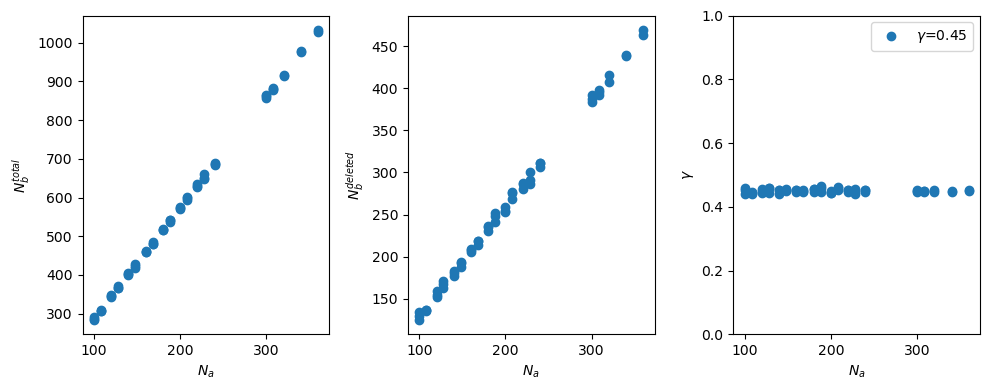

In [18]:
nodes = [len(n.atoms) for n in init_networks]
bonds = [len(n.bonds) for n in init_networks]
deleted_bonds = [len(ed) for ed in init_elastic_data]
portion = [d/b for b, d in zip(bonds, deleted_bonds)]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), layout='tight')

ax[0].scatter(nodes, bonds)
ax[0].set_xlabel("$N_a$")
ax[0].set_ylabel("$N_b^{total}$")

ax[1].scatter(nodes, deleted_bonds)
ax[1].set_xlabel("$N_a$")
ax[1].set_ylabel("$N_b^{deleted}$")

ax[2].scatter(nodes, portion, label=f"$\\gamma$={np.mean(np.array(portion)):.2f}")
ax[2].set_xlabel("$N_a$")
ax[2].set_ylabel("$\\gamma$")
ax[2].set_ylim(0.0, 1.0)
ax[2].legend()

plt.show()